<a href="https://colab.research.google.com/github/zwubbena/sample-size-tables/blob/main/sample_size_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶ Processing Scenario A (80%, ±13%) (CL=80.0%, ±13.0%)...
▶ Processing Scenario B (80%, ±16%) (CL=80.0%, ±15.5%)...
▶ Processing Scenario C (80%, ±16%) (CL=80.0%, ±16.0%)...
▶ Creating line graph...


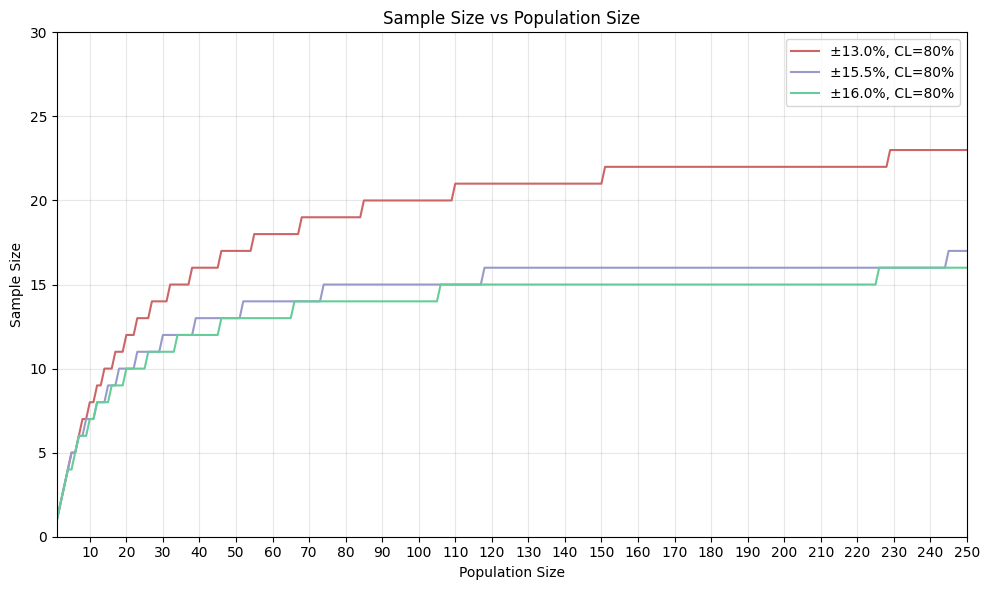

▶ Exporting to Excel...
▶ Generating graph for Scenario A (80%, ±13%)...
▶ Generating graph for Scenario B (80%, ±16%)...
▶ Generating graph for Scenario C (80%, ±16%)...
✓ Excel file created: /content/20250725_Sample_Size_Table_Known_Population.xlsx

Sample size analysis successfully completed!
View graph above or download:
Excel: /content/20250725_Sample_Size_Table_Known_Population.xlsx
Graph: /content/inline_plot.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================================
# Script Name : sample_size_table.ipynb
# Purpose     : Calculate and visualize sample size tables for known populations
#               with difference margin of errors and different confidence levels
# Author      : Zane Wubbena, PhD
# Platform    : Google Colab
# Last Updated: 2025-07-24
# =============================================================================

# =============================================================================
# SECTION 1: Import Required Libraries
# =============================================================================

import os
import math
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from matplotlib.lines import Line2D
from datetime import datetime

!pip install -q xlsxwriter

# =============================================================================
# SECTION 2: User-Defined Parameters
# =============================================================================

# --- Scenario Control ---
RUN_SINGLE = False  # Set True to run only one scenario
SINGLE_SCENARIO_INDEX = 0  # Index of scenario to run if RUN_SINGLE = True

# Common z-score references for documentation
#  Z = 1.28  → 80% Confidence
#  Z = 1.645 → 90% Confidence
#  Z = 1.96  → 95% Confidence
#  Z = 2.576 → 99% Confidence

# --- Display Settings ---
POP_MIN = 1             # Minimum population size to display on the graph
POP_MAX = 250           # Maximum population size to display on the graph
# POP_MAX_ALL = 20000   # Total population size range used in calculations (not displayed)
SAMPLE_CAP = 30         # Maximum sample size shown on the graph

X_TICK_START = 0        # Starting point for x-axis ticks
X_TICK_INTERVAL = 10    # Interval between x-axis ticks

Y_TICK_START = 0        # Starting point for y-axis ticks
Y_TICK_INTERVAL = 5     # Interval between y-axis ticks

OUTPUT_DIR = "/content/"

# --- Raw Scenario Values ---
SCENARIOS = [
    # Scenario A
    {
        "Z": 1.28,
        "Margin": 0.13,
        "Proportion": 0.50,
        "LineStyle": "-", #":"
        "LineColor": "#CC6666",
    },
    # Scenario B
    {
        "Z": 1.28,
        "Margin": 0.155,
        "Proportion": 0.50,
        "LineStyle": "-", # "--"
        "LineColor": "#9999CC",
    },
    # Scenario C
    {
        "Z": 1.28,
        "Margin": 0.16,
        "Proportion": 0.50,
        "LineStyle": "-",
        "LineColor": "#66CC99",
    },
]

# --- Dynamically Generate Scenario Names ---
for idx, scenario in enumerate(SCENARIOS):
    confidence = round(2 * stats.norm.cdf(scenario["Z"]) - 1, 4)
    confidence_str = f"{round(confidence * 100)}%"
    margin_str = f"±{round(scenario['Margin'] * 100)}%"
    scenario["Name"] = f"Scenario {chr(65 + idx)} ({confidence_str}, {margin_str})"

# =============================================================================
# SECTION 3: Sample Size Calculation Function
# =============================================================================

def calculate_sample_size(N, e, p, z):
    """
    Calculate sample size with finite population correction.
    """
    if N < 1:
        raise ValueError("Population must be >= 1")

    numerator = (z ** 2) * p * (1 - p)
    denominator = e ** 2
    n_0 = numerator / denominator
    adjusted_n = n_0 / (1 + ((n_0 - 1) / N))
    return min(math.ceil(adjusted_n), N)

# =============================================================================
# SECTION 4: Run All or Single Scenario(s)
# =============================================================================

scenarios_to_run = [SCENARIOS[SINGLE_SCENARIO_INDEX]] if RUN_SINGLE else SCENARIOS
plot_df = pd.DataFrame()
scenario_summary = []

for scenario in scenarios_to_run:
    name = scenario["Name"]
    z = scenario["Z"]
    e = scenario["Margin"]
    p = scenario["Proportion"]

    confidence = round(2 * stats.norm.cdf(z) - 1, 4)
    print(f"▶ Processing {name} (CL={confidence*100:.1f}%, ±{e*100:.1f}%)...")

    # Generate full sample size dataset
    df = pd.DataFrame({
        "Population_Size": range(1, 20001)
    })
    df["Sample_Size"] = df["Population_Size"].apply(lambda N: calculate_sample_size(N, e, p, z))
    df["Truncated_Sample_Size"] = df["Sample_Size"].apply(lambda x: min(x, SAMPLE_CAP))

    # Group population ranges by sample size
    grouped = df.groupby("Sample_Size")["Population_Size"].agg(["min", "max"]).reset_index()
    grouped["Population_Range"] = grouped.apply(
        lambda row: f"{row['min']}" if row["min"] == row["max"]
        else f"{row['min']}-{row['max']}", axis=1
    )
    grouped = grouped[["Sample_Size", "Population_Range"]]

    # Save summary info
    max_sample = df["Sample_Size"].max()
    scenario_summary.append({
        "Scenario": name,
        "Z-Score": z,
        "Confidence_Level": f"{round(confidence*100)}%",
        "Margin_of_Error": f"±{round(e*100)}%",
        "Max_Sample_Size": max_sample
    })

    # Save plot-specific data
    temp = df[df["Population_Size"].between(POP_MIN, POP_MAX)].copy()
    temp["Scenario"] = name
    temp["LineStyle"] = scenario["LineStyle"]
    temp["LineColor"] = scenario["LineColor"]
    plot_df = pd.concat([plot_df, temp], ignore_index=True)

    # Save grouped range data for Excel
    scenario["DataFrame_Grouped"] = grouped

# =============================================================================
# SECTION 5: Create Line Graph in Google Colab
# =============================================================================

print("▶ Creating line graph...")
plt.figure(figsize=(10, 6))

for scenario in scenarios_to_run:
    temp = plot_df[plot_df["Scenario"] == scenario["Name"]]

    # Dynamically calculate label for legend
    confidence_level = 2 * stats.norm.cdf(scenario["Z"]) - 1
    label = f"±{scenario['Margin']*100:.1f}%, CL={round(confidence_level * 100)}%"


    # Plot each scenario
    plt.plot(
        temp["Population_Size"],
        temp["Truncated_Sample_Size"],
        label=label,
        linestyle=scenario["LineStyle"],
        color=scenario["LineColor"],
        linewidth=1.5
    )

plt.xlabel("Population Size")
plt.ylabel(f"Sample Size")
plt.title("Sample Size vs Population Size")
plt.xticks(range(X_TICK_START, POP_MAX + 1, X_TICK_INTERVAL))
plt.yticks(range(0, SAMPLE_CAP+1, Y_TICK_INTERVAL))
plt.ylim(0, SAMPLE_CAP)
plt.xlim(POP_MIN, POP_MAX)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()

# Save plot image
graph_path = os.path.join(OUTPUT_DIR, "inline_plot.png")
plt.savefig(graph_path, dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SECTION 6: Export to Excel
# =============================================================================

print("▶ Exporting to Excel...")
today_str = datetime.today().strftime("%Y%m%d")
excel_filename = f"{today_str}_Sample_Size_Table_Known_Population.xlsx"
excel_path = os.path.join(OUTPUT_DIR, excel_filename)
# excel_path = os.path.join(OUTPUT_DIR, "sample_size_output.xlsx")
summary_df = pd.DataFrame(scenario_summary)

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    # Sheet: Scenario Summary + All-Scenario Graph
    summary_df.to_excel(writer, sheet_name="Scenario Summary", index=False)
    workbook = writer.book

    # Define header format (color fill, bold text, centered)
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#F7F7F8',
        'border': 1,
        'align': 'center',
        'valign': 'vcenter'
    })

    summary_ws = writer.sheets["Scenario Summary"]
    summary_ws.set_column('A:E', 22)

    # Apply header format to each column in Scenario Summary
    for col_num, value in enumerate(summary_df.columns.values):
        summary_ws.write(0, col_num, value, header_format)

    if os.path.exists(graph_path):
        # Reposition the all-scenario graph to start at cell A7
        summary_ws.insert_image("A7", graph_path, {"x_scale": 0.8, "y_scale": 0.8})

    # Sheets: Per-Scenario (Table + Single-Line Graph)
    for scenario in scenarios_to_run:
        scenario_name = scenario["Name"]  # e.g., "Scenario A (80%, ±13%)"
        grouped = scenario["DataFrame_Grouped"]

        # Create scenario-specific graph
        print(f"▶ Generating graph for {scenario_name}...")
        plt.figure(figsize=(10, 6))
        temp = plot_df[plot_df["Scenario"] == scenario_name]
        plt.plot(
            temp["Population_Size"],
            temp["Truncated_Sample_Size"],
            label=scenario_name,
            linestyle=scenario["LineStyle"],
            color=scenario["LineColor"],
            linewidth=2
        )
        plt.xlabel("Population Size")
        plt.ylabel(f"Sample Size")
        plt.title(f"Sample Size vs Population Size\n{scenario_name}")
        plt.xticks(range(X_TICK_START, POP_MAX + 1, X_TICK_INTERVAL))
        plt.yticks(range(0, SAMPLE_CAP + 1, Y_TICK_INTERVAL))
        plt.ylim(0, SAMPLE_CAP)
        plt.xlim(POP_MIN, POP_MAX)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')
        plt.tight_layout()

        # Save unique graph for this scenario
        graph_filename = f"plot_{scenario_name.split()[1]}.png".replace("%", "")
        graph_path_scenario = os.path.join(OUTPUT_DIR, graph_filename)
        plt.savefig(graph_path_scenario, dpi=300, bbox_inches='tight')
        plt.close()

        # Write data and graph to sheet
        grouped.to_excel(writer, sheet_name=scenario_name, index=False)
        ws = writer.sheets[scenario_name]
        ws.set_column('A:B', 25)

        # Apply header format to each column in the grouped data
        for col_num, value in enumerate(grouped.columns.values):
            ws.write(0, col_num, value, header_format)

        if os.path.exists(graph_path_scenario):
            # Insert image starting at cell C2
            ws.insert_image("C2", graph_path_scenario, {"x_scale": 0.8, "y_scale": 0.8})

print(f"✓ Excel file created: {excel_path}")

# =============================================================================
# SECTION 7: Completion Message
# =============================================================================

print("\n" + "="*60)
print("Sample size analysis successfully completed!")
print("="*60)
print(f"View graph above or download:")
print(f"Excel: {excel_path}")
print(f"Graph: {graph_path}")

# Automatically download file to computer
from google.colab import files
files.download(excel_path)

# =============================================================================
# Python Program End
# =============================================================================